# Laboratorium 3

### Konfiguracja

In [549]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [550]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

## Rozwiązanie


### Dodaj tu punkty i/lub odcinki!

<IPython.core.display.Javascript object>


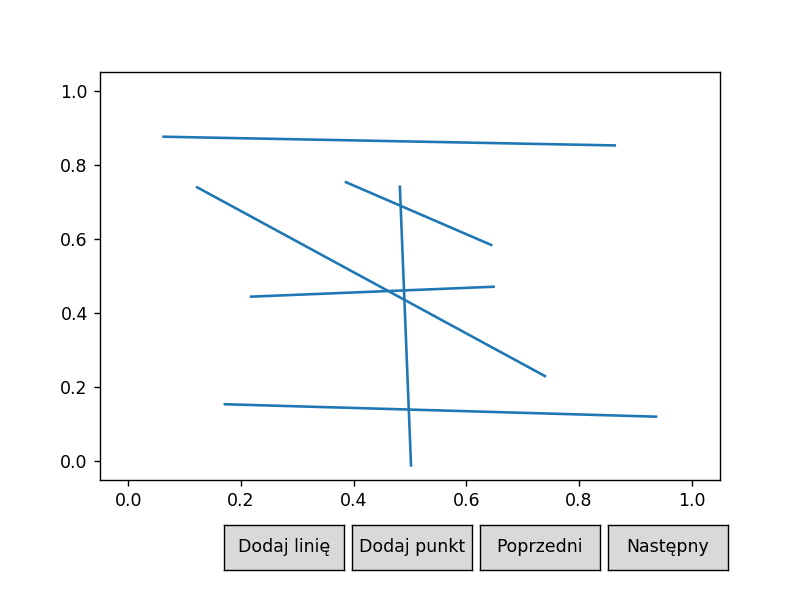

In [551]:
plot_to_draw = Plot()
plot_to_draw.draw()


In [552]:
%matplotlib notebook

lines_from_previous_plot = plot_to_draw.get_added_lines()

def generate_segments(n, x_range, y_range):
    result = []
    set_of_points = set()
    while n > 0:
        x_1 = np.random.uniform(x_range[0], x_range[1])
        x_2 = np.random.uniform(x_range[0], x_range[1])
        if x_1 != x_2:
            y_1 = np.random.uniform(y_range[0], y_range[1])
            y_2 = np.random.uniform(y_range[0], y_range[1])
            while (x_1,y_1) in set_of_points:
                y_1 = np.random.uniform(y_range[0], y_range[1])
            set_of_points.add((x_1, y_1))
            while (x_2,y_2) in set_of_points:
                y_2 = np.random.uniform(y_range[0], y_range[1])
            set_of_points.add((x_2, y_2))
            if x_2 > x_1:
                segment = ((x_1, y_1), (x_2, y_2))
            else:
                segment = ((x_2, y_2), (x_1, y_1))
            result.append(segment)
            n-=1
    return result

segments = generate_segments(5, [0, 1], [0, 1])

scenes = [Scene([], lines_from_previous_plot),
          Scene([], [LinesCollection(segments)]),
          Scene([], lines_from_previous_plot + [LinesCollection(segments)]),]

with open('first_plot.json', 'w') as file:
    file.write(Plot(scenes).toJson())

<IPython.core.display.Javascript object>


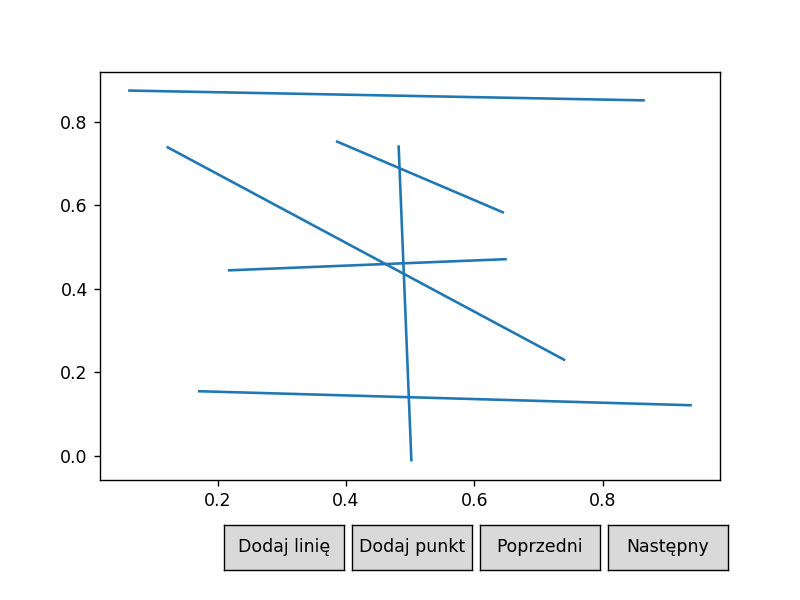

In [553]:
%matplotlib notebook
with open('first_plot.json', 'r') as file:
    json = file.read()
    
plot = Plot(json=json)
plot.draw()


# Algorithm for one point

<IPython.core.display.Javascript object>


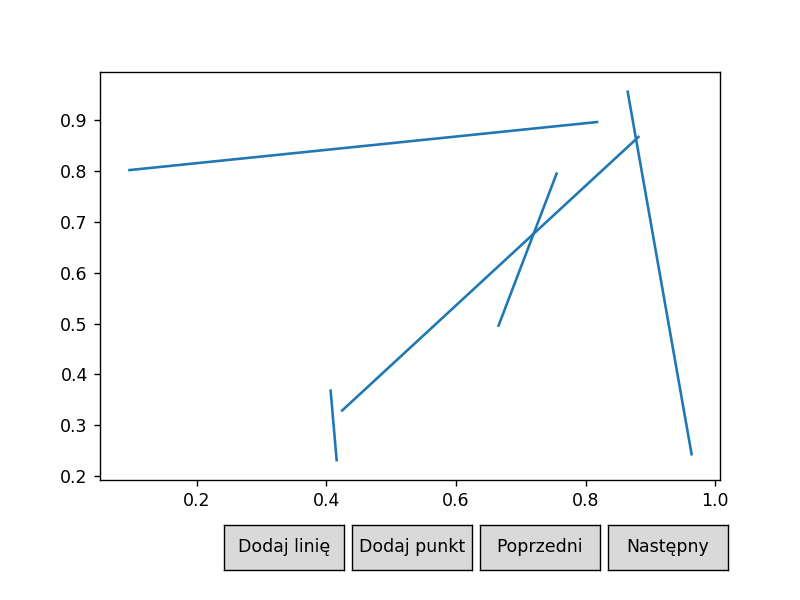

In [555]:
%matplotlib notebook

from queue import PriorityQueue
import copy 

def line_intersection(segment_1, segment_2):
    xdiff = (segment_1[0][0] - segment_1[1][0], segment_2[0][0] - segment_2[1][0])
    ydiff = (segment_1[0][1] - segment_1[1][1], segment_2[0][1] - segment_2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       return None

    d = (det(*segment_1), det(*segment_2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def find_crossing_point(segment_1, segment_2):
    crossing_point = line_intersection(segment_1, segment_2)
    if crossing_point is not None:
        if (segment_1[0][0] <= crossing_point[0] <= segment_1[1][0]
                and min(segment_1[0][1], segment_1[1][1]) <= crossing_point[1] <= max(segment_1[0][1], segment_1[1][1])
                and segment_2[0][0] <= crossing_point[0] <= segment_2[1][0]
                and min(segment_2[0][1], segment_2[1][1]) <= crossing_point[1] <= max(segment_2[0][1], segment_2[1][1])):
            return crossing_point
    return None

def get_y(segment, x):
    (x_1, y_1), (x_2, y_2) = segment
    return (y_1-y_2)/(x_1-x_2)*x + (y_1-(y_1-y_2)/(x_1-x_2)*x_1) #a*x + b

def find_segment_cross(segments, debug = False):
    scenes = []
    Q = PriorityQueue()
    # T = tree()  TODO
    T = []
    for segment in segments:
        Q.put((segment[0][0], segment))
        Q.put((segment[1][0], segment))
    if debug: scenes.append(Scene([], [LinesCollection(segments)]))
    while not Q.empty():
        x, segment = Q.get()
        if x == segment[0][0]:
            T.append(segment)
            if debug:
                scenes.append(Scene([PointsCollection([[x, get_y(segment, x)]], color="green")],
                                    [LinesCollection(copy.deepcopy(segments)),
                                     LinesCollection([[[x,0], [x, 1]]], color="red"),
                                     LinesCollection(copy.deepcopy(T), color="orange"),
                                     ]))
            T.sort(key = lambda seg: get_y(seg, x))
            i = T.index(segment)
            if i > 0:                
                crossing_point = find_crossing_point(T[i-1], segment)
                if crossing_point is not None:
                    if debug: return crossing_point, scenes
                    return crossing_point
            if i+1 < len(T): 
                crossing_point = find_crossing_point(T[i+1], segment)
                if crossing_point is not None:
                    if debug: return crossing_point, scenes
                    return crossing_point
        else:
            i = T.index(segment)
            if i > 0 and i+1 < len(T):
                crossing_point = find_crossing_point(T[i-1], T[i+1])
                if crossing_point is not None:
                    if debug: 
                        scenes.append(Scene([PointsCollection([[x, get_y(segment, x)]], color="green")],
                                    [LinesCollection(copy.deepcopy(segments)),
                                     LinesCollection([[[x,0], [x, 1]]], color="red"),
                                     LinesCollection(copy.deepcopy(T), color="orange"),
                                     ]))
                        return crossing_point, scenes
                    return crossing_point
            T.pop(i)
            if debug:
                scenes.append(Scene([PointsCollection([[x, get_y(segment, x)]], color="green")],
                                    [LinesCollection(copy.deepcopy(segments)),
                                     LinesCollection([[[x,0], [x, 1]]], color="red"),
                                     LinesCollection(copy.deepcopy(T), color="orange"),
                                     ]))
    if debug: return None, scenes
    return None
    
segments = generate_segments(5, [0, 1], [0, 1])
point, scenes = find_segment_cross(segments, debug=True)
if point is not None:
    scenes.append(Scene(
        [PointsCollection([point], color="purple")],
                                    [LinesCollection(segments),]
    ))
plot = Plot(scenes)
plot.draw()


<IPython.core.display.Javascript object>


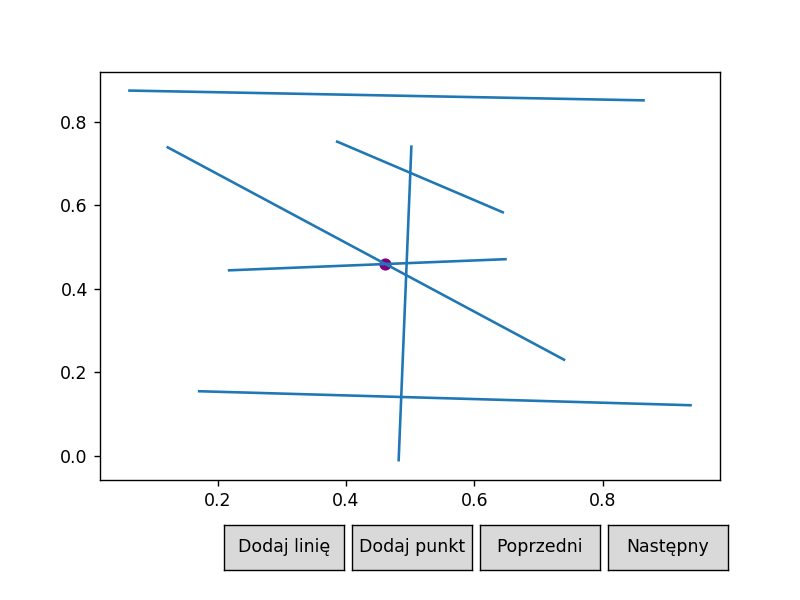

In [556]:
%matplotlib notebook

with open('first_plot.json', 'r') as f:
    plot_help = Plot(json=f.read())
    segments = plot_help.scenes[0].lines[0].lines
    for segment in segments:
        if segment[0][0] > segment[1][0]:
            segment[1][0], segment[0][0] = segment[0][0], segment[1][0]

point, scenes = find_segment_cross(segments, debug=True)
if point is not None:
    scenes.append(Scene(
        [PointsCollection([point], color="purple")],
                                    [LinesCollection(segments),]
    ))
plot = Plot(scenes)
plot.draw()

# Algorithm for multiple points


In [557]:
class PrioritySet(object):
    def __init__(self):
        self.queue = PriorityQueue()
        self.set = set()

    def put(self, element):
        index, segment = element
        if not index in self.set:
            self.queue.put(element)
            self.set.add(index)

    def get(self):
        pri, element = self.queue.get()
        self.set.remove(pri)
        return pri, element
    
    def empty(self):
        return self.queue.empty()

def find_segment_crosses(segments, debug = False):
    scenes = []
    results = []
    Q = PrioritySet()
    # T = tree()  TODO
    T = []
    for segment in segments:
        Q.put((segment[0][0], segment))
        Q.put((segment[1][0], segment))
    if debug: scenes.append(Scene([], [LinesCollection(segments)]))
    while not Q.empty():
        x, segment = Q.get()
        if type(segment) is list and x == segment[0][0]:
            T.append(segment)
            if debug:
                scenes.append(Scene([PointsCollection([[x, get_y(segment, x)]], color="green"),
                                     PointsCollection([result["point"] for result in  results], color="purple"),
                                     ],
                                    [LinesCollection(copy.deepcopy(segments)),
                                     LinesCollection([[[x,0], [x, 1]]], color="red"),
                                     LinesCollection(copy.deepcopy(T), color="orange"),
                                     ]))
            T.sort(key = lambda seg: get_y(seg, x))
            i = T.index(segment)
            if i > 0:                
                crossing_point = find_crossing_point(T[i-1], segment)
                if crossing_point is not None:
                    Q.put((crossing_point[0], {
                    "segment_1": T[i-1],
                    "segment_2": segment,
                }))
            if i+1 < len(T): 
                crossing_point = find_crossing_point(T[i+1], segment)
                if crossing_point is not None:
                    Q.put((crossing_point[0], {
                    "segment_1": T[i+1],
                    "segment_2": segment,
                }))
        elif type(segment) is list and x == segment[1][0]:
            i = T.index(segment)
            if i > 0 and i+1 < len(T):
                crossing_point = find_crossing_point(T[i-1], T[i+1])
                if crossing_point is not None:
                    Q.put((crossing_point[0], {
                        "segment_1": T[i-1],
                        "segment_2": T[i+1],
                    }))
            T.pop(i)
            if debug:
                scenes.append(Scene([PointsCollection([[x, get_y(segment, x)]], color="green"),
                                     PointsCollection([result["point"] for result in  results], color="purple"),],
                                    [LinesCollection(copy.deepcopy(segments)),
                                     LinesCollection([[[x,0], [x, 1]]], color="red"),
                                     LinesCollection(copy.deepcopy(T), color="orange"),
                                     ]))
        else:            
            segment_1 = segment["segment_1"]
            segment_2 = segment["segment_2"]
            i = T.index(segment_1)
            j = T.index(segment_2)
            T[i], T[j] = T[j], T[i]
            if i > 0:                
                crossing_point = find_crossing_point(T[i-1], segment_2)
                if crossing_point is not None:
                    Q.put((crossing_point[0], {
                    "segment_1": T[i-1],
                    "segment_2": segment_2,
                }))
            if i+1 < len(T): 
                crossing_point = find_crossing_point(T[i+1], segment_1)
                if crossing_point is not None:
                    Q.put((crossing_point[0], {
                    "segment_1": T[i+1],
                    "segment_2": segment_1,
                }))
            if debug:
                scenes.append(Scene([PointsCollection([[x, get_y(segment_1, x)]], color="green"),
                                     PointsCollection([result["point"] for result in  results], color="purple"),],
                                    [LinesCollection(copy.deepcopy(segments)),
                                     LinesCollection([[[x,0], [x, 1]]], color="red"),
                                     LinesCollection(copy.deepcopy(T), color="orange"),
                                     ]))
            results.append({
                "point": [x, get_y(segment_1, x)],
                "segment_1": segment_1,
                "segment_2": segment_2,
            })
    if debug: return len(results), results, scenes
    return len(results), results

<IPython.core.display.Javascript object>


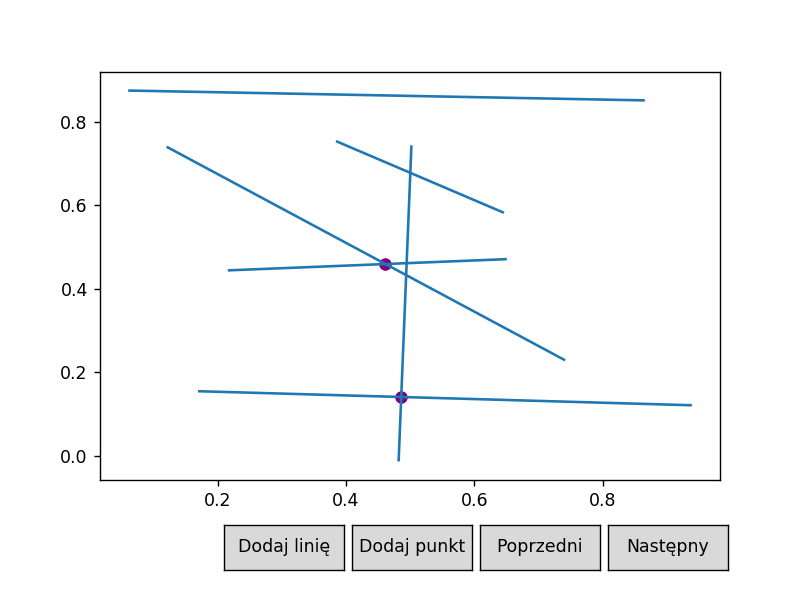

In [558]:
%matplotlib notebook

with open('first_plot.json', 'r') as f:
    plot_help = Plot(json=f.read())
    segments = plot_help.scenes[0].lines[0].lines
    for segment in segments:
        if segment[0][0] > segment[1][0]:
            segment[1][0], segment[0][0] = segment[0][0], segment[1][0]

size, results, scenes = find_segment_crosses(segments, debug=True)
if point is not None:
    scenes.append(Scene(
        [PointsCollection([result["point"] for result in  results], color="purple")],
                                    [LinesCollection(segments),]
    ))
plot = Plot(scenes)
plot.draw()